# Stability of identity 2v-2e-2v network

Purpose: To do a linear stability analysis of a PC network with 2 inputs and 2 outputs.

In [1]:
import numpy as np
np.set_printoptions(precision=4)
import copy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [83]:
def Decomp(z, show=False):
    x = z[:2]
    e = z[2:4]
    y = z[4:6]
    M0 = np.reshape(z[6:10], (2,2))
    M1 = np.reshape(z[10:14], (2,2))
    if show:
        print('x = '+str(x))
        print('e = '+str(e))
        print('y = '+str(y))
        print('M0 = '+str(M0[0]))
        print('     '+str(M0[1]))
        print('M1 = '+str(M1[0]))
        print('     '+str(M1[1]))
    return x, e, y, M0, M1

def Recomp(x, e, y, M0, M1):
    return np.concatenate((x,e,y,M0.flatten(),M1.flatten()))

In [84]:
# 2v-2e-2v PC network
def pc(t, z):
    '''
     z consist of:
        z[0-1]   x (input layer)
        z[2-3]   e
        z[4-5]   y (output layer)
        z[6-9]   M0 (weights for x-->e)
        z[10-13] M1 (weights for e<--y)
    '''
    x = z[0:2]
    e = z[2:4]
    y = z[4:6]
    M0 = np.reshape(z[6:10], (2,2))
    M1 = np.reshape(z[10:], (2,2))
    
    s0 = 1.
    s1 = -1.
    
    tau = 0.05
    gamma = 0.1
        
    dxdt = ( -s0 * M0.T@e * alpha ) / tau
    dedt = ( s0*M0@x + s1*M1@y - e ) / tau
    dydt = ( -s1 * M1.T@e * beta ) / tau
    dM0dt = ( -s0*np.outer(e,x) ) / gamma
    dM1dt = ( -s1*np.outer(e,y) ) / gamma
    
    
    dzdt = np.concatenate((dxdt, dedt, dydt, dM0dt.flatten(), dM1dt.flatten()))
    return dzdt

In [ ]:
def Train(net, iters):
    for k in range(iters):
        

In [225]:
# Ideal Equilibrium
alpha = 1.
beta = 1.
rho = 0.05
lam = 0.05
X = np.array([[1,0],[0,1]], dtype=float)
Y = np.array([[1,0],[0,1]], dtype=float)
x0 = X[0]
e0 = np.zeros(2)
y0 = Y[0]
M0 = np.eye(2) #np.random.randn(2,2)
M1 = np.eye(2) #np.random.randn(2,2)
z0 = Recomp(x0, e0, y0, M0, M1)

In [184]:
# De-something Equilibrium
alpha = 1.
beta = 1.
X = np.array([[1,0],[0,1]], dtype=float)
Y = np.array([[1,0],[0,1]], dtype=float)
x0 = X[0]
e0 = np.zeros(2)
y0 = Y[0]
M0 = np.zeros((2,2)) #np.random.randn(2,2)
M1 = np.zeros((2,2)) #np.random.randn(2,2)
z0 = Recomp(x0, e0, y0, M0, M1)

In [174]:
# Random
alpha = 0.
beta = 1.
x0 = np.random.rand(2)
e0 = np.random.rand(2)
y0 = np.random.rand(2)
M0 = np.random.randn(2,2)
M1 = np.random.randn(2,2)
z0 = Recomp(x0, e0, y0, M0, M1)

In [226]:
tspan = [0, 10]
sol = solve_ivp(pc, tspan, z0)

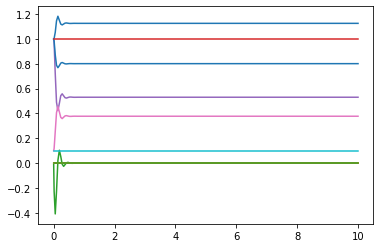

In [227]:
for y in sol.y:
    plt.plot(sol.t, y);

In [228]:
Decomp(z0, show=True);

x = [1. 0.]
e = [0. 0.]
y = [1. 0.]
M0 = [0.1 0. ]
     [0.  0.1]
M1 = [1. 0.]
     [0. 1.]


In [229]:
x,e,y,M0,M1 = Decomp(sol.y[:,-1], show=True)

x = [1.1252 0.    ]
e = [2.0385e-06 0.0000e+00]
y = [0.5304 0.    ]
M0 = [0.3775 0.    ]
     [0.  0.1]
M1 = [0.8008 0.    ]
     [0. 1.]


## Linear system

In [216]:
def LinSys(z):
    L = np.zeros((len(z), len(z)), dtype=float)
    x,e,y,M0,M1 = Decomp(z)
    s0 = 1.
    s1 = -1.
    # dxdt
    L[0:2,2:4]   = -s0*M0.T  # e
    L[0,6:8]     = -s0*e       # W0
    L[1,8:10]    = -s0*e       # W0
    # dedt
    L[2:4,0:2]   = s0*M0
    L[2:4,2:4]   = -np.eye(2)
    L[2:4,4:6]   = s1*M1
    L[2,6:8]     = s0*x
    L[3,8:10]    = s0*x
    L[2,10:12]   = s1*y
    L[3,12:14]   = s1*y
    # dydt
    L[4:6,2:4]   = -s1*M1.T
    L[4,10:12]   = -s1*e
    L[5,12:14]   = -s1*e
    # dM0dt
    L[6:8,0:2]  = -s0*np.diag(e)
    L[8:10,0:2] = -s0*np.diag(e)
    L[6:8,2]    = -s0*x
    L[8:10,3]   = -s0*x
    L[6:10,6:10] = np.eye(4) * (rho/np.linalg.norm(M0, ord='fro') - lam)
    # dM1dt
    L[10:12,2]   = -s1*y
    L[12:14,3]   = -s1*y
    L[10:12,4:6] = -s1*np.diag(e)
    L[12:14,4:6] = -s1*np.diag(e)
    L[10:14,10:14] = np.eye(4) * (rho/np.linalg.norm(M1, ord='fro') - lam)
    
    return L

In [208]:
rho = 0.05
lam = 0.05

In [217]:
L = LinSys(z0)

In [218]:
evals, evecs = np.linalg.eig(L)
print(evals)

[-5.0246e-01+1.6621j -5.0246e-01-1.6621j -9.7149e-03+0.j
 -2.9176e-17+0.j     -5.0246e-01+1.6621j -5.0246e-01-1.6621j
  8.7752e-17+0.j     -9.7149e-03+0.j     -1.4645e-02+0.j
 -1.4645e-02+0.j     -1.4645e-02+0.j     -1.4645e-02+0.j
 -1.4645e-02+0.j     -1.4645e-02+0.j    ]


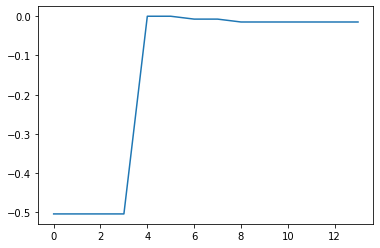

In [210]:
plt.plot(evals);

In [146]:
import sympy